# CNN Implementation for the Simpsons Characters Recognition

In [ ]:
# paste below in your terminal after activating your conda environment
# git clone https://github.com/Yichen-Wang-2003/M156_Group1_Final_project

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import os

In [ ]:
print(os.getcwd())
torch.cuda.is_available()
import torch
print(torch.__version__)
print(torch.version.cuda)
import sys
print(sys.executable)


C:\Users\madis\Desktop\M156_Group1_Final_project-main
2.1.1+cu121
12.1
C:\Users\madis\anaconda3\envs\text2\python.exe


In [ ]:
 #os.chdir('')

In [ ]:
print(os.getcwd())

C:\Users\madis\Desktop\M156_Group1_Final_project-main


## 1. Data Processing and Dataloader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

data = datasets.ImageFolder(root='./archive/simpsons_dataset', transform=transform)

dataloader = DataLoader(data, batch_size=64, shuffle=True, num_workers=2)

def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = get_mean_std(dataloader)

print(f'mean: {mean}')
print(f'std: {std}')

mean: tensor([0.4624, 0.4077, 0.3524])
std: tensor([0.2442, 0.2214, 0.2536])


In [ ]:
print(len(data.classes))

42


In [ ]:
# data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(),
                         std=std.tolist())
])

data = datasets.ImageFolder(root='./archive/simpsons_dataset', transform=transform)

# split the dataset into training and validation
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

# create data loaders for training, validation, and testing
train = DataLoader(train_data, batch_size=64, shuffle=True)
val = DataLoader(val_data, batch_size=64, shuffle=False)
test = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
print(len(data.classes))

42


In [ ]:
print(f'found {len(train_data)} images belonging to {len(data.classes)} classes in the training set.')
print(f'found {len(val_data)} images belonging to {len(data.classes)} classes in the validation set.')
print(f'found {len(test_data)} images belonging to {len(data.classes)} classes in the validation set.')

found 16746 images belonging to 42 classes in the training set.
found 2093 images belonging to 42 classes in the validation set.
found 2094 images belonging to 42 classes in the validation set.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
import time


In [ ]:
torch.manual_seed(42)  # for reproducibility

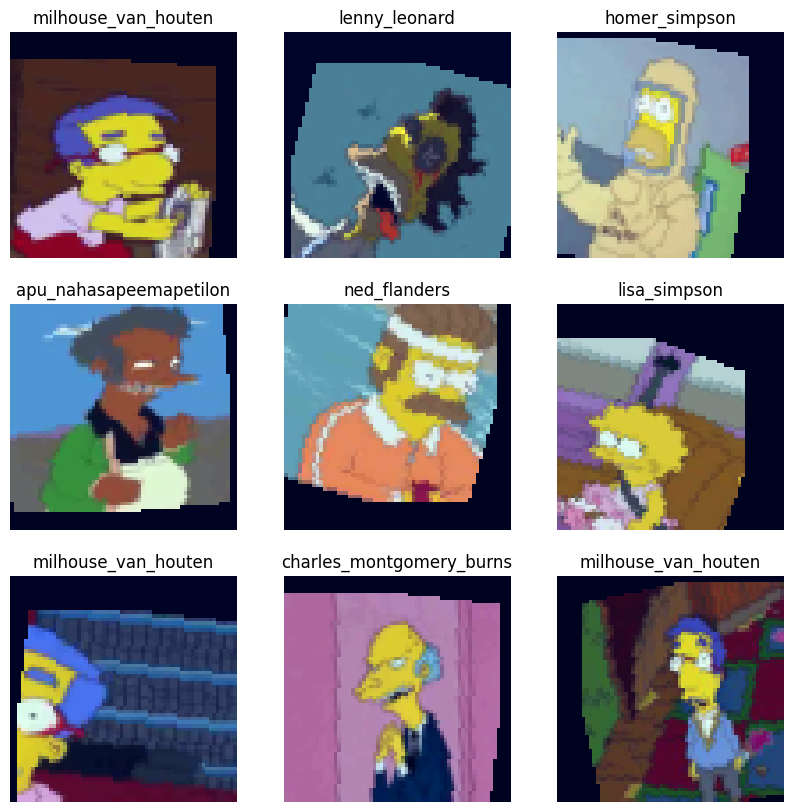

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'train' is your DataLoader for the training set
dataiter = iter(train)
images, labels = next(dataiter)  # Get a batch of images and labels

class_names = data.classes  # Assuming this gives you the list of class names

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].numpy().transpose((1, 2, 0))  # Convert from torch tensor to numpy and fix the channel order
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [ ]:
dataloaders = {
    'train': train,
    'val': val
}
dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data)
}


## 2. Convolutional Neural Network and Resnet Block for Simpson Character Recognition

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResnetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.downsample = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):

        i = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += i
        out = self.relu1(out)
        return out

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Added BatchNorm
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Conv
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Added BatchNorm
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Conv
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Two resnet layers
        self.ResnetBlock1 = ResnetBlock(128, 128)
        self.ResnetBlock2 = ResnetBlock(128, 128)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(8192, 1024)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(512, num_figure)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.maxpool1(x)

        x = self.relu2(self.conv2(x))
        x = self.maxpool2(x)

        x = self.relu3(self.conv3(x))
        x = self.maxpool3(x)

        x = self.ResnetBlock1(x)
        x = self.ResnetBlock2(x)

        x = self.dropout(x)

        x = x.view(x.size(0), -1)

        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)
        return x

## 3. Training phase and validation

In [ ]:
# number of Simpson characters
num_figure = 42
epoch_limit = 100
model = ConvNet()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = model.to(device)

# Set criterion to be CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Using L2 regularization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Setup scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Setup early stopping
stop_training = False
count_early_stop = 0
best_loss = None


# Set some thing to store and keep track of the best model
val_loss = []
val_acc = []
train_loss = []
train_acc = []
epoch_update = 0

start_time = time.time()
# keep training until early stop met or reach epoch limit
while not stop_training and epoch_update < epoch_limit:

  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    running_loss = 0.0
    running_corrects = 0
    # iterate over data
    for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        if phase == 'train':
          loss.backward()
          optimizer.step()

      # update loss
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    if(phase == 'train'):
      train_loss.append(epoch_loss)
      train_acc.append(epoch_acc)
    else:
      val_loss.append(epoch_loss)
      val_acc.append(epoch_acc)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # check early stop conditions for every epoch
    if phase == 'val':
      if best_loss == None or epoch_loss < best_loss:
        best_loss = epoch_loss
        count_early_stop = 0
        torch.save(model.state_dict(), 'best_model.pt')
      else:
        count_early_stop += 1
        if count_early_stop > 3:  # stop if validation loss does not improve for 3 epochs
          stop_training = True
      epoch_update += 1

  scheduler.step()

end_time= time.time()
elapsed_time = end_time - start_time
print(f"The code ran for {elapsed_time} seconds.")

cuda
train Loss: 2.4459 Acc: 0.3182
val Loss: 2.4443 Acc: 0.3674
train Loss: 1.5845 Acc: 0.5580
val Loss: 1.4797 Acc: 0.6087
train Loss: 1.2243 Acc: 0.6528
val Loss: 1.2441 Acc: 0.6613
train Loss: 1.0423 Acc: 0.7010
val Loss: 1.1508 Acc: 0.6799
train Loss: 0.8958 Acc: 0.7457
val Loss: 1.4640 Acc: 0.6273
train Loss: 0.7944 Acc: 0.7739
val Loss: 0.9088 Acc: 0.7611
train Loss: 0.7316 Acc: 0.7890
val Loss: 0.8374 Acc: 0.7831
train Loss: 0.5847 Acc: 0.8305
val Loss: 0.7098 Acc: 0.8060
train Loss: 0.5409 Acc: 0.8457
val Loss: 0.6762 Acc: 0.8161
train Loss: 0.5281 Acc: 0.8497
val Loss: 0.6711 Acc: 0.8256
train Loss: 0.5168 Acc: 0.8545
val Loss: 0.6678 Acc: 0.8247
train Loss: 0.5008 Acc: 0.8552
val Loss: 0.6802 Acc: 0.8227
train Loss: 0.4957 Acc: 0.8582
val Loss: 0.6617 Acc: 0.8280
train Loss: 0.4908 Acc: 0.8617
val Loss: 0.6315 Acc: 0.8352
train Loss: 0.4710 Acc: 0.8653
val Loss: 0.6575 Acc: 0.8247
train Loss: 0.4747 Acc: 0.8627
val Loss: 0.6354 Acc: 0.8380
train Loss: 0.4649 Acc: 0.8674
val 

In [ ]:
print(epoch_update)

25


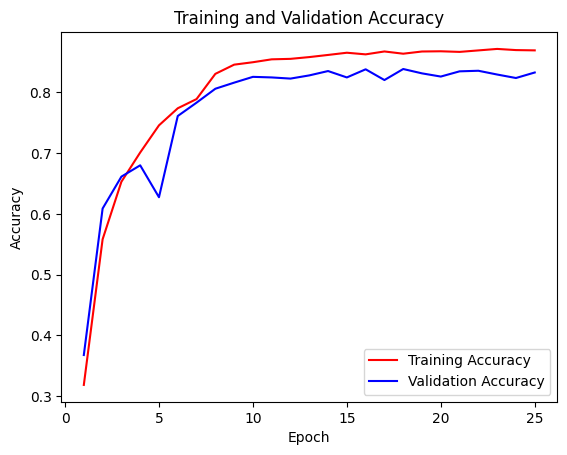

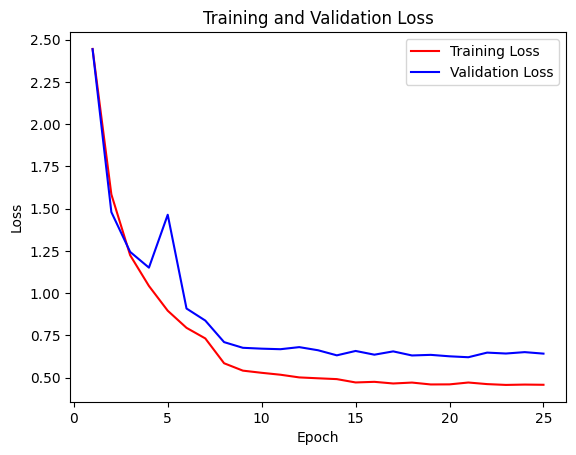

In [ ]:
# # Visualize the validaton accuracy and training accuracy
epochs = list(range(1, epoch_update+1))
# Convert lists of tensors to lists of scalars
train_acc_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc]
val_acc_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in val_acc]
train_loss_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss]
val_loss_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in val_loss]

# Convert lists of tensors to lists of scalars
train_acc_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc]
val_acc_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in val_acc]
train_loss_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss]
val_loss_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in val_loss]

# Now you can safely plot
plt.plot(epochs, train_acc_cpu, label='Training Accuracy', color='red')
plt.plot(epochs, val_acc_cpu, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_loss_cpu, label='Training Loss', color='red')
plt.plot(epochs, val_loss_cpu, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



## 4. Test set evaluation

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

model.load_state_dict(torch.load('best_model.pt'))
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0

# Prestored for visualization
images_num = 10
s_images = []
s_preds = []
s_truth = []
y_true = []
y_pred = []
with torch.no_grad():  # Do not calculate gradient
    for inputs, labels in test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()  # Sum up batch loss
        pred = outputs.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

        # Select some images to visualize
        if len(s_images) < images_num:
            s_images.extend(inputs.cpu().data[:images_num-len(s_images)])
            s_preds.extend(pred.view(-1).cpu().data[:images_num-len(s_preds)])
            s_truth.extend(labels.cpu().data[:images_num-len(s_truth)])

test_loss /= len(test.dataset)
test_accuracy = 100. * correct / len(test.dataset)
print(f'Testset result: Average loss: {test_loss:.5f}, Accuracy: {correct}/{len(test.dataset)} ({test_accuracy:.2f}%)')


Testset result: Average loss: 0.00975, Accuracy: 1763/2094 (84.19%)


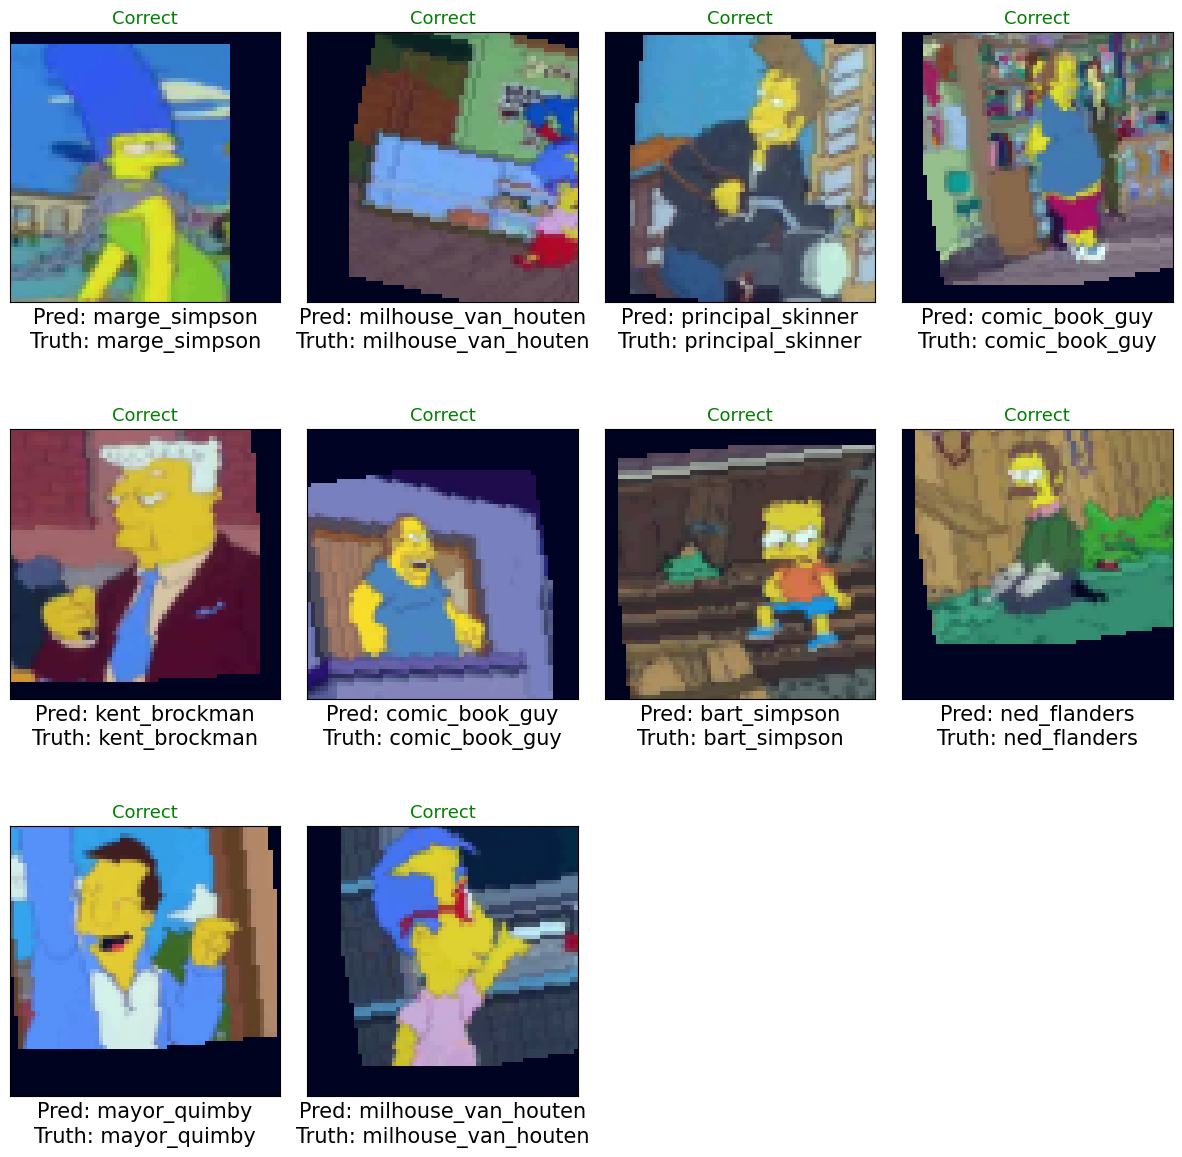

In [ ]:
import matplotlib.pyplot as plt
import textwrap

def visualize_predictions(images, predictions, truths, images_num=10):

    class_names = data.classes
    images_to_show = min(len(images), images_num)
    rows = int(images_to_show ** 0.5)
    cols = images_to_show // rows + (images_to_show % rows > 0)

    wrapper = textwrap.TextWrapper(width=30)

    plt.figure(figsize=(15, 15))
    for i in range(images_to_show):
        ax = plt.subplot(rows, cols, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        if predictions[i]== truths[i]:
            judgetext = 'Correct'
        else:
            judgetext = 'Wrong'
        pred_text = wrapper.fill(f'Pred: {class_names[predictions[i]]}')
        true_text = wrapper.fill(f'Truth: {class_names[truths[i]]}')
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(f'{pred_text}\n{true_text}', fontsize=15)
        if judgetext == 'Correct':
            plt.title(judgetext, fontsize=13, color = 'green')
        else:
            plt.title(judgetext, fontsize=13, color = 'red')
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

# Example usage
visualize_predictions(s_images, s_preds, s_truth, images_num)



In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from IPython.display import display, HTML

class_names = data.classes

y_true = np.array(y_true)
y_pred = np.array(y_pred)


unique_labels = np.unique(y_true)


target_names = [class_names[label] for label in unique_labels]


report = classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names, zero_division=0)

display(HTML(f'<pre style="font-size: 16px">{report}</pre>'))

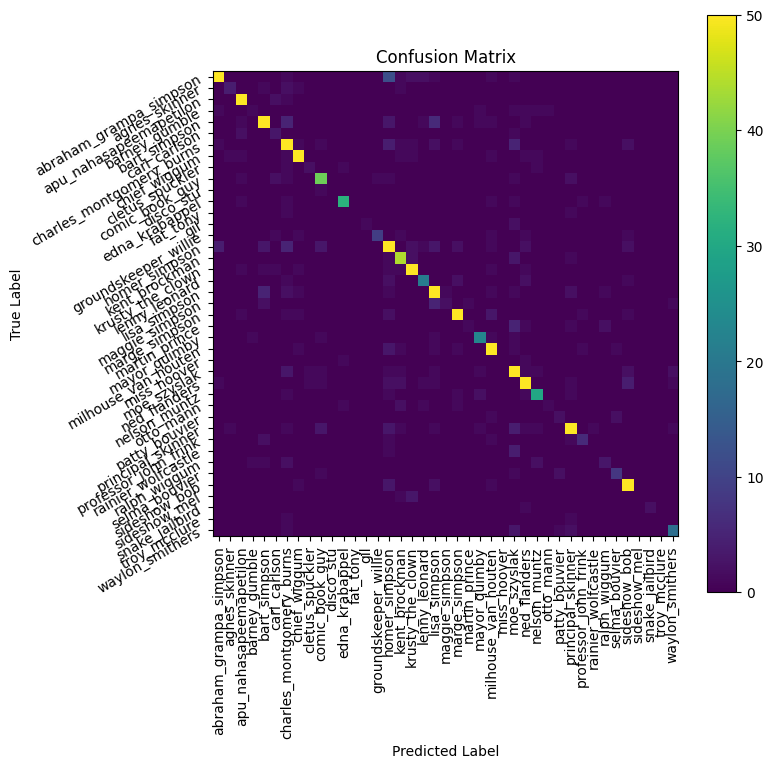

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

cnf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
classes = target_names

plt.figure(figsize=(7.5,7.5))

plt.imshow(cnf_matrix, interpolation='nearest', cmap='viridis', vmin=0, vmax=50)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)  # Rotation changed to 30
plt.yticks(tick_marks, classes, rotation=30)  # Optionally rotate y ticks as well

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [2]:
train_loss = [2.4459, 1.5845, 1.2243, 1.0423, 0.8958, 0.7944, 0.7316, 0.5847, 0.5409, 0.5281, 0.5168, 0.5008, 0.4957, 0.4908, 0.4710, 0.4747, 0.4649, 0.4703, 0.4591, 0.4596, 0.4706, 0.4612, 0.4564, 0.4584, 0.4572]
val_loss = [2.4443, 1.4797, 1.2441, 1.1508, 1.4640, 0.9088, 0.8374, 0.7098, 0.6762, 0.6711, 0.6678, 0.6802, 0.6617, 0.6315, 0.6575, 0.6354, 0.6550, 0.6308, 0.6344, 0.6258, 0.6203, 0.6477, 0.6423, 0.6505, 0.6417]
train_accuracy = [0.3182, 0.5580, 0.6528, 0.7010, 0.7457, 0.7739, 0.7890, 0.8305, 0.8457, 0.8497, 0.8545, 0.8552, 0.8582, 0.8617, 0.8653, 0.8627, 0.8674, 0.8637, 0.8674, 0.8677, 0.8667, 0.8692, 0.8697, 0.8692, 0.8692]
val_accuracy = [0.3674, 0.6087, 0.6613, 0.6799, 0.6273, 0.7611, 0.7831, 0.8060, 0.8161, 0.8256, 0.8247, 0.8227, 0.8280, 0.8352, 0.8247, 0.8380, 0.8204, 0.8385, 0.8313, 0.8261, 0.8347, 0.8356, 0.8294, 0.8237, 0.8328]
import matplotlib.pyplot as plt
# import plotly
import plotly.graph_objs as go
import plotly.express as px
epochs = list(range(1, len(val_loss)))
# Adjusting figure properties
layout_args = {
    'title': {'text': '', 'x': 0.5, 'font': {'size': 20}},
    'xaxis_title': 'Epoch',
    'yaxis_title': '',
    'xaxis': {'tickmode': 'array', 'tickvals': epochs, 'title_font': {'size': 16}, 'tickfont': {'size': 14}},
    'yaxis': {'title_font': {'size': 16}, 'tickfont': {'size': 14}},
    'legend': {'font': {'size': 14}},
    'width': 1000,  # Adjust the width to make the plot narrower
    'height': 500
}

# Plot for Train Loss vs Validation Loss
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Train Loss'))
fig1.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss'))
layout_args['title']['text'] = 'Train vs Validation Loss'
layout_args['yaxis_title'] = 'Loss'
fig1.update_layout(**layout_args)
fig1.show()

# Plot for Train Accuracy vs Validation Accuracy
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=epochs, y=train_accuracy, mode='lines+markers', name='Train Accuracy'))
fig2.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines+markers', name='Validation Accuracy'))
layout_args['title']['text'] = 'Train vs Validation Accuracy'
layout_args['yaxis_title'] = 'Accuracy'
fig2.update_layout(**layout_args)
fig2.show()